#Video Processing File
## Code to Process Videos and Evaluate Models on those videos


# Install Packages

In [2]:
!pip install -q pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00


# imports

In [3]:
import cv2
import os
import time
import pandas as pd
from pytube import YouTube
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt

Mounted at /content/drive


In [4]:
# download video files from youtube
workingdir = '/content/drive/MyDrive/DeepLearning/MilitaryObjectDetection/videos'
url_filename = 'video_urls.csv'

url_csv = pd.read_csv(os.path.join(workingdir, url_filename), header=None)
urls = url_csv[0]
labels = url_csv[1]

for i in range(len(urls)):
    link = urls[i]
    yt = YouTube(link)
    video_stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    filename = str(i) + '_' + labels[i] + '.mp4'
    video_stream.download(output_path=workingdir, filename=filename)

In [5]:
# Gets frames from a video given a filepath
def get_frames(video_path):
    capture = cv2.VideoCapture(video_path)
    if (capture.isOpened()== False):
        print("Error opening video stream or file")
    frame_n = 0
    frames = []

    while(True):
        _, frame = capture.read()
        if _:
            frames.append(frame)
        else:
            break
        frame_n += 1

    capture.release()

    return frames

In [6]:
# Defines a custom VideoDataset for pytorch
class CustomVideoDataset(Dataset):
    def __init__(self, frames, label, transform=None):
        self.frames = frames
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        if self.transform is not None:
            frame = self.transform(frame)

        return frame, self.label


transform_to_tensor = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# returns a video dataset given video path
def getVideoDataset(video_path, label):
    return CustomVideoDataset(get_frames(video_path), label_encoder.transform([label]), transform=transform_to_tensor)

In [7]:
# Code to encode classes
from sklearn.preprocessing import LabelEncoder

Labels = []
rootdir = '/content/drive/MyDrive/DeepLearning/MilitaryObjectDetection/archive/crop'
for dirs in os.listdir(rootdir):
    Labels.append(dirs)

label_encoder = LabelEncoder()
label_encoder.fit(Labels)

LabelEncoder()

In [8]:
def get_model(file):
    mod_path = "/content/drive/MyDrive/DeepLearning/MilitaryObjectDetection/models"
    model_path = os.path.join(mod_path, file)
    print(f"Evaluating {file}")
    if file == 'faster_rcnn_model_0.pth':
        model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        num_classes = 43  # Specify the number of classes in your dataset
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    elif file == 'AlexNet_19.pth':
        model = models.alexnet()
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 47)
    elif file == 'VGG-16_19.pth':
        model = models.vgg16()
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 47)
    elif file == 'ResNet50_19.pth':
        model = models.resnet50()
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 47)
    elif file == 'ResNet50FPN_19.pth':
        model = models.resnet50()
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 47)
    else:
        print("Model not found")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    return model
model_files = ["faster_rcnn_model_0.pth","ResNet50_19.pth", "ResNet50FPN_19.pth", "VGG-16_19.pth", "AlexNet_19.pth"]

In [9]:
videos = []
labels = []

for file in os.listdir(workingdir):
    if file.endswith('.mp4'):
        videos.append(os.path.join(workingdir, file))
        labels.append(file.split('_')[1].split('.')[0])

In [10]:
# Code to load a single video for processing and evaluation
video_path = '/content/drive/MyDrive/DeepLearning/MilitaryObjectDetection/videos/mv22.mp4'

dataset = getVideoDataset(video_path, 'V22')
dataloader = DataLoader(dataset, batch_size=32, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Error opening video stream or file


In [11]:
# Code to clean GPU mem - use as needed when resources are all used up
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [12]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

files = ['AlexNet_19.pth', 'VGG-16_19.pth', 'ResNet50_19.pth', 'ResNet50FPN_19.pth', "faster_rcnn_model_0.pth",]

model_predictions = {}
speedict = {}

for file in files:
    model = get_model(file)
    model.eval()
    model_predictions[file] = {}
    speedict[file] = {}

    for i, video in enumerate(videos):
        predictions = []
        dataset = getVideoDataset(video, labels[i])
        size = len(dataset)
        print(size)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        start = time.time()
        with torch.no_grad():
            for batch in dataloader:
                inputs, _ = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                if file != "faster_rcnn_model_0.pth":
                  probs = torch.nn.functional.softmax(outputs, dim=1)
                  preds = torch.argmax(probs, dim=1)

                  predictions.extend(preds.tolist())
        end = time.time()

        predictions_decoded = label_encoder.inverse_transform(predictions)
        videoname = os.path.basename(video)
        model_predictions[file][videoname] = predictions_decoded

        print(f"{file} took {end - start} seconds for {videoname} - with a FPS of {size/(end - start)}")
        speedict[file][videoname] = size/(end - start)


print(speedict)

speed_df = pd.DataFrame.from_dict(speedict)
predictions_df = pd.DataFrame.from_dict(model_predictions)

Evaluating AlexNet_19.pth
753
AlexNet_19.pth took 6.543022632598877 seconds for 0_C17.mp4 - with a FPS of 115.0844253920775
784
AlexNet_19.pth took 6.041376352310181 seconds for 1_V22.mp4 - with a FPS of 129.7717530377335
654
AlexNet_19.pth took 4.89201545715332 seconds for 2_C5.mp4 - with a FPS of 133.68723090269316
286
AlexNet_19.pth took 2.1497318744659424 seconds for 3_F22.mp4 - with a FPS of 133.03984715352047
497
AlexNet_19.pth took 3.856550693511963 seconds for 4_EF2000.mp4 - with a FPS of 128.87163672867672
132
AlexNet_19.pth took 1.0305566787719727 seconds for 5_Rafale.mp4 - with a FPS of 128.0861137664871
375
AlexNet_19.pth took 1.3639988899230957 seconds for 6_A10.mp4 - with a FPS of 274.9269099633527
1226
AlexNet_19.pth took 4.6837615966796875 seconds for 7_B2.mp4 - with a FPS of 261.7554234334023
575
AlexNet_19.pth took 4.2509894371032715 seconds for 8_B1.mp4 - with a FPS of 135.2626273265499
638
AlexNet_19.pth took 5.074422597885132 seconds for 9_AV8B.mp4 - with a FPS of 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.0MB/s]


753
faster_rcnn_model_0.pth took 66.23387098312378 seconds for 0_C17.mp4 - with a FPS of 11.368805549533146
784
faster_rcnn_model_0.pth took 67.00517582893372 seconds for 1_V22.mp4 - with a FPS of 11.700588653055343
654
faster_rcnn_model_0.pth took 56.18777084350586 seconds for 2_C5.mp4 - with a FPS of 11.639543448369226
286
faster_rcnn_model_0.pth took 24.684778690338135 seconds for 3_F22.mp4 - with a FPS of 11.58608726404921
497
faster_rcnn_model_0.pth took 42.534459352493286 seconds for 4_EF2000.mp4 - with a FPS of 11.68464364108267
132
faster_rcnn_model_0.pth took 11.268048524856567 seconds for 5_Rafale.mp4 - with a FPS of 11.714539541502395
375
faster_rcnn_model_0.pth took 30.702240228652954 seconds for 6_A10.mp4 - with a FPS of 12.214092431275754
1226
faster_rcnn_model_0.pth took 100.35548710823059 seconds for 7_B2.mp4 - with a FPS of 12.216571662671452
575
faster_rcnn_model_0.pth took 49.38308501243591 seconds for 8_B1.mp4 - with a FPS of 11.643663004350588
638
faster_rcnn_model

In [13]:
# save fps values and predictions
speed_df.to_csv(os.path.join(workingdir, 'fps.csv'))
predictions_df.to_csv(os.path.join(workingdir, 'predictions.csv'))

In [14]:
f = open('/content/drive/MyDrive/DeepLearning/MilitaryObjectDetection/videos/predictions.txt', 'wt')
f.write(str(model_predictions))

151398

In [15]:
# average FPS
average_fps = {}
for key in speedict.keys():
    average_fps[key] = sum(speedict[key].values()) / len(speedict[key].values())

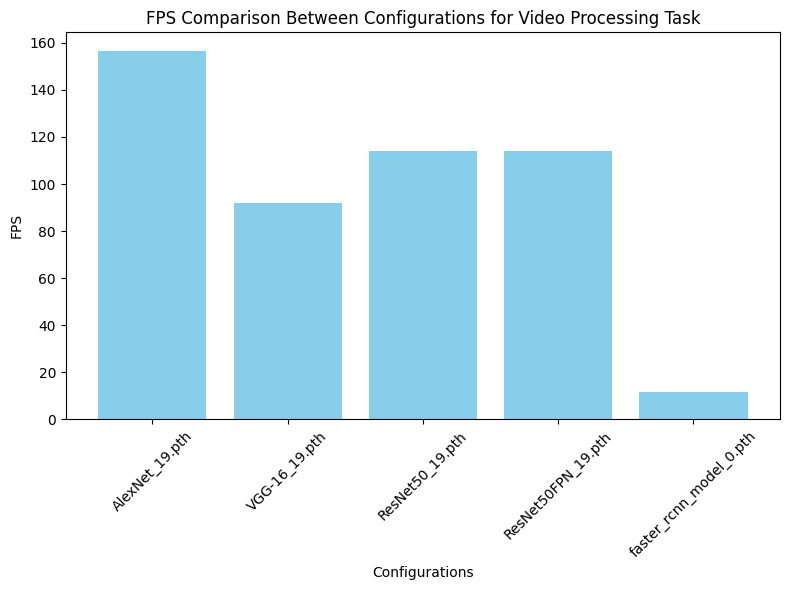

In [16]:
# average FPS


# Extracting the keys and values from the dictionary
configs = list(average_fps.keys())
speedups = list(average_fps.values())

# Plotting the speedup values
plt.figure(figsize=(8, 6))
plt.bar(configs, speedups, color='skyblue')
plt.xlabel('Configurations')
plt.ylabel('FPS')
plt.title('FPS Comparison Between Configurations for Video Processing Task')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [28]:
# given file name function will produce a visualization for that video path
files = ['AlexNet_19.pth', 'VGG-16_19.pth', 'ResNet50_19.pth', 'ResNet50FPN_19.pth']
def visualize_predictions(filename):
    label = filename.split('_')[1].split('.')[0]
    accuracies = {}

    fig, axs = plt.subplots(1, 4, figsize=(40, 6))
    for i, model_name in enumerate(files):
        predictions = predictions_df.loc[filename].loc[model_name]

        correct_indices = [i for i, pred_class in enumerate(predictions) if pred_class == label]
        correct_predictions = [1 if i in correct_indices else 0 for i in range(len(predictions))]
        accuracies[model_name] = sum(correct_predictions) / len(predictions)

        plt.sca(axs[i])
        time_range = range(len(predictions))
        plt.scatter(time_range, correct_predictions, label=f'{model_name} - {label} Predictions', c=correct_predictions, cmap='cool', alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel(f'{label} Prediction Value')
        plt.ylim((-0.3, 1.3))
        plt.title(f'{label} Predictions over Time for {model_name}')
        plt.legend()
        plt.colorbar(label='Prediction Value')  # Add color bar for reference

    plt.show()
    return accuracies

# # Iterate through each model's predictions and create separate time plots
# for model_name, predictions in model_predictions.items():
#     # Filter predictions where the predicted class is 'V22'
#     v22_indices = [i for i, pred_class in enumerate(predictions) if pred_class == 'V22']

#     # Create a list with 1s for 'V22' predictions and 0s for others
#     v22_predictions = [1 if i in v22_indices else 0 for i in range(len(predictions))]

#     # Create a time range from 0 to 783 for x-axis (based on 784 predictions)
#     time_range = range(0, 784)  # Adjusted from 0 to 783 inclusive

#     # Plot predictions for the current model on separate plots
#     plt.scatter(time_range, v22_predictions, label=f'{model_name} - V22 Predictions', c=v22_predictions, cmap='cool', alpha=0.5)
#     plt.xlabel('Time')
#     plt.ylabel('V22 Prediction Value')
#     plt.title(f'V22 Predictions over Time for {model_name}')
#     plt.legend()
#     plt.colorbar(label='Prediction Value')  # Add color bar for reference
#     plt.show()

In [29]:
# printing file names
print([os.path.basename(video) for video in videos])

['0_C17.mp4', '1_V22.mp4', '2_C5.mp4', '3_F22.mp4', '4_EF2000.mp4', '5_Rafale.mp4', '6_A10.mp4', '7_B2.mp4', '8_B1.mp4', '9_AV8B.mp4']


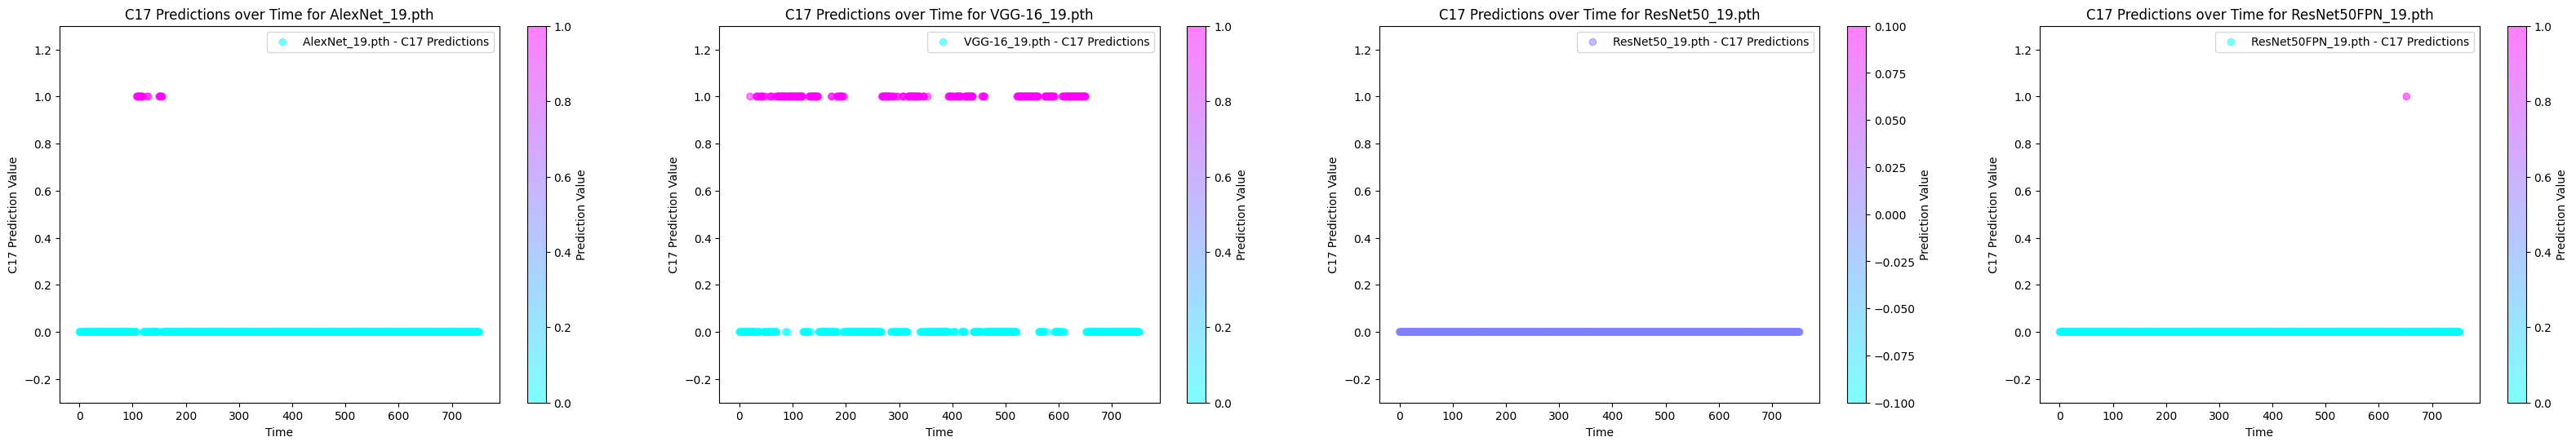

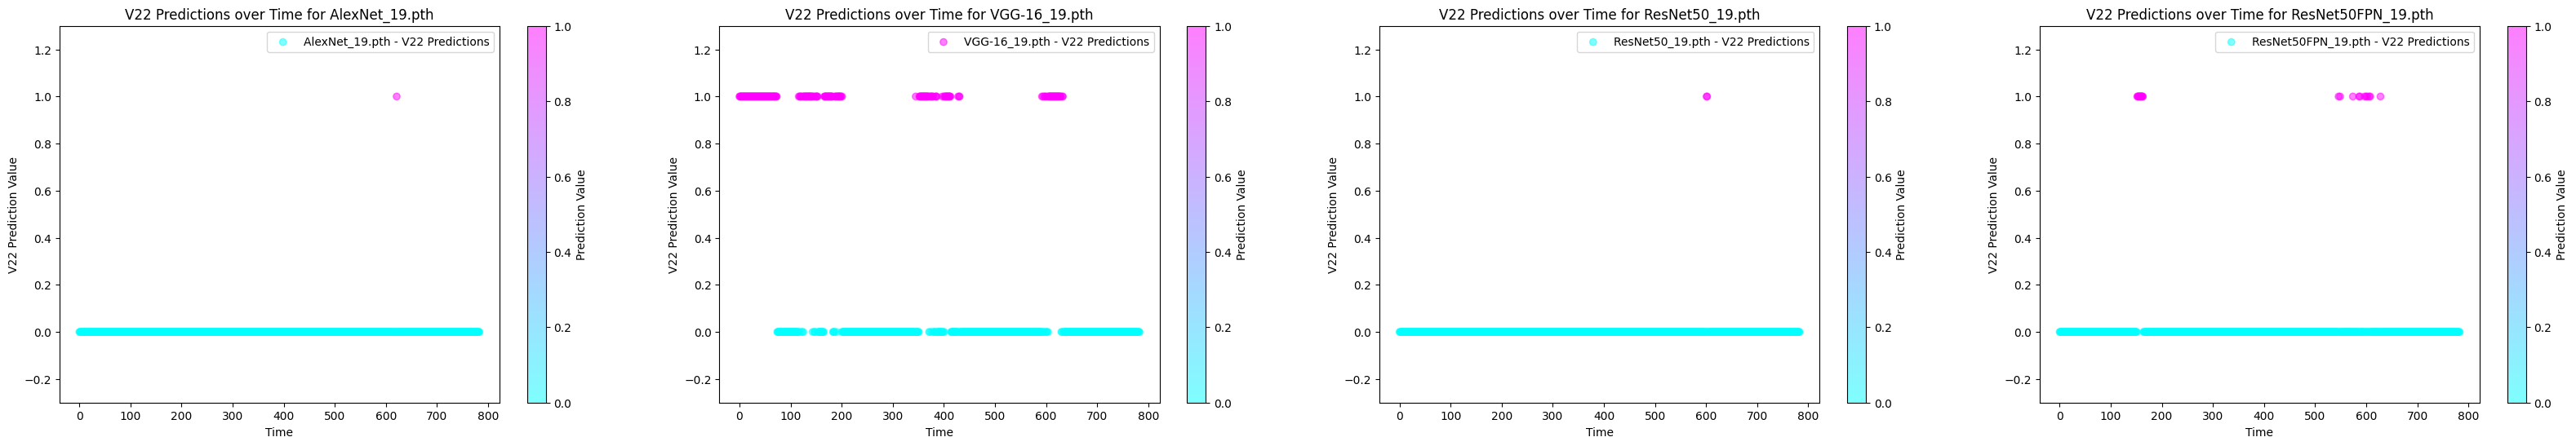

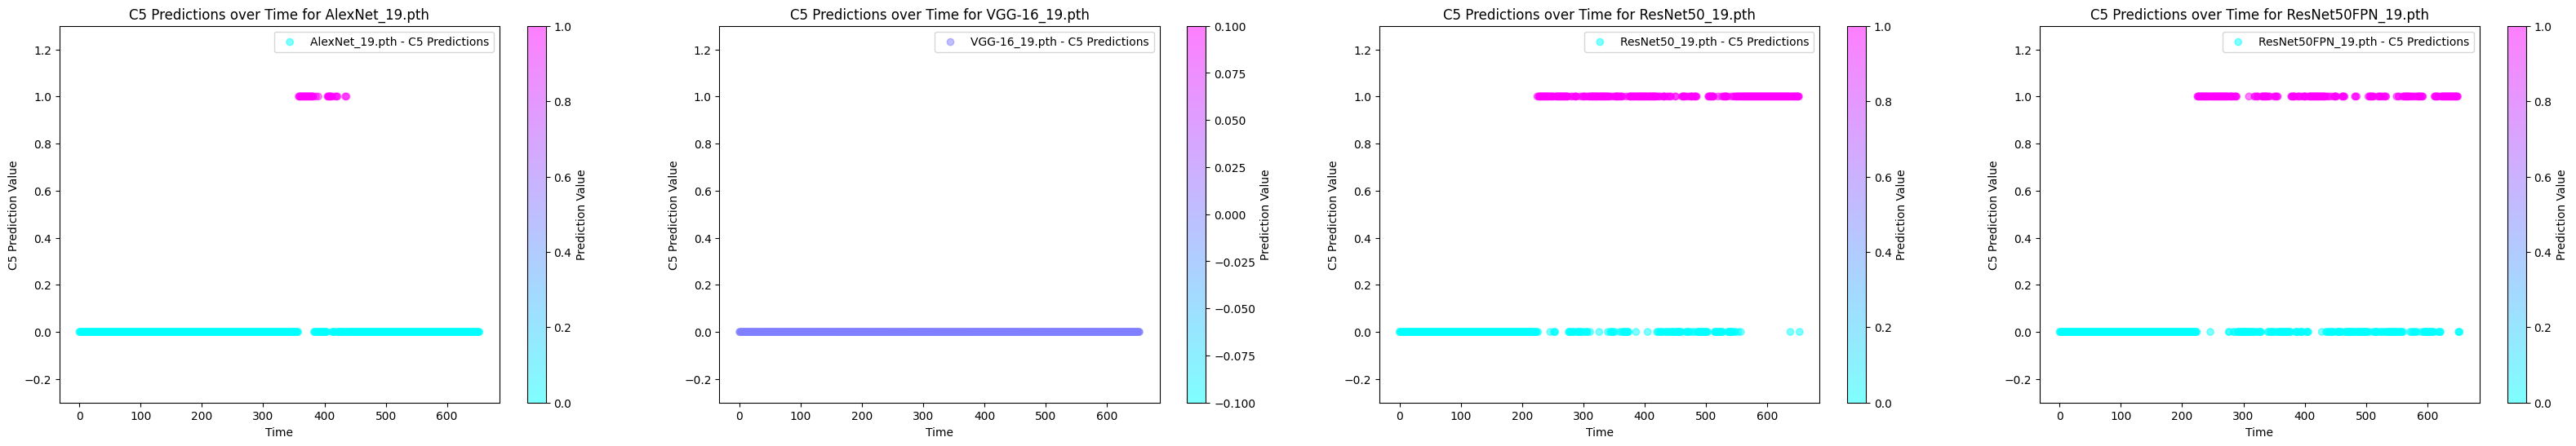

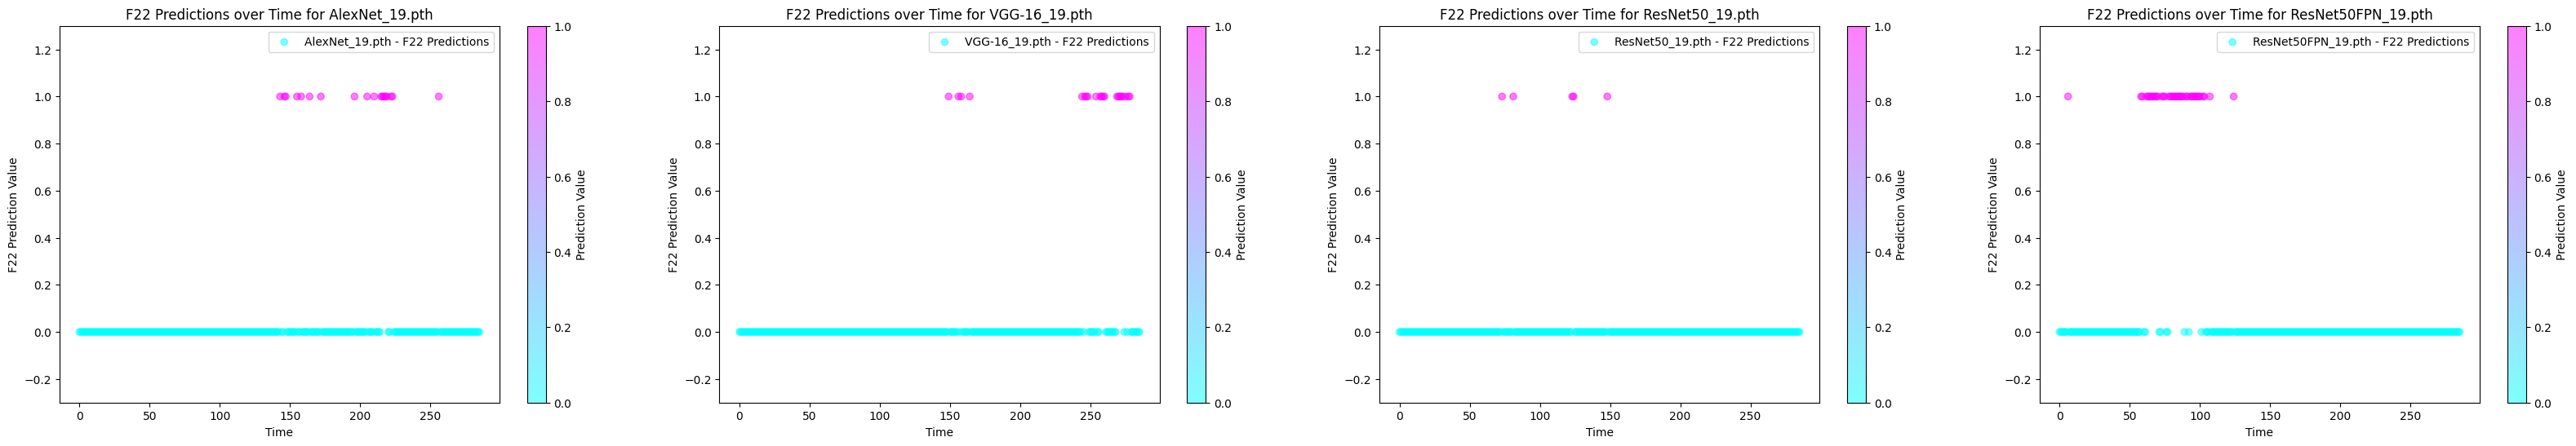

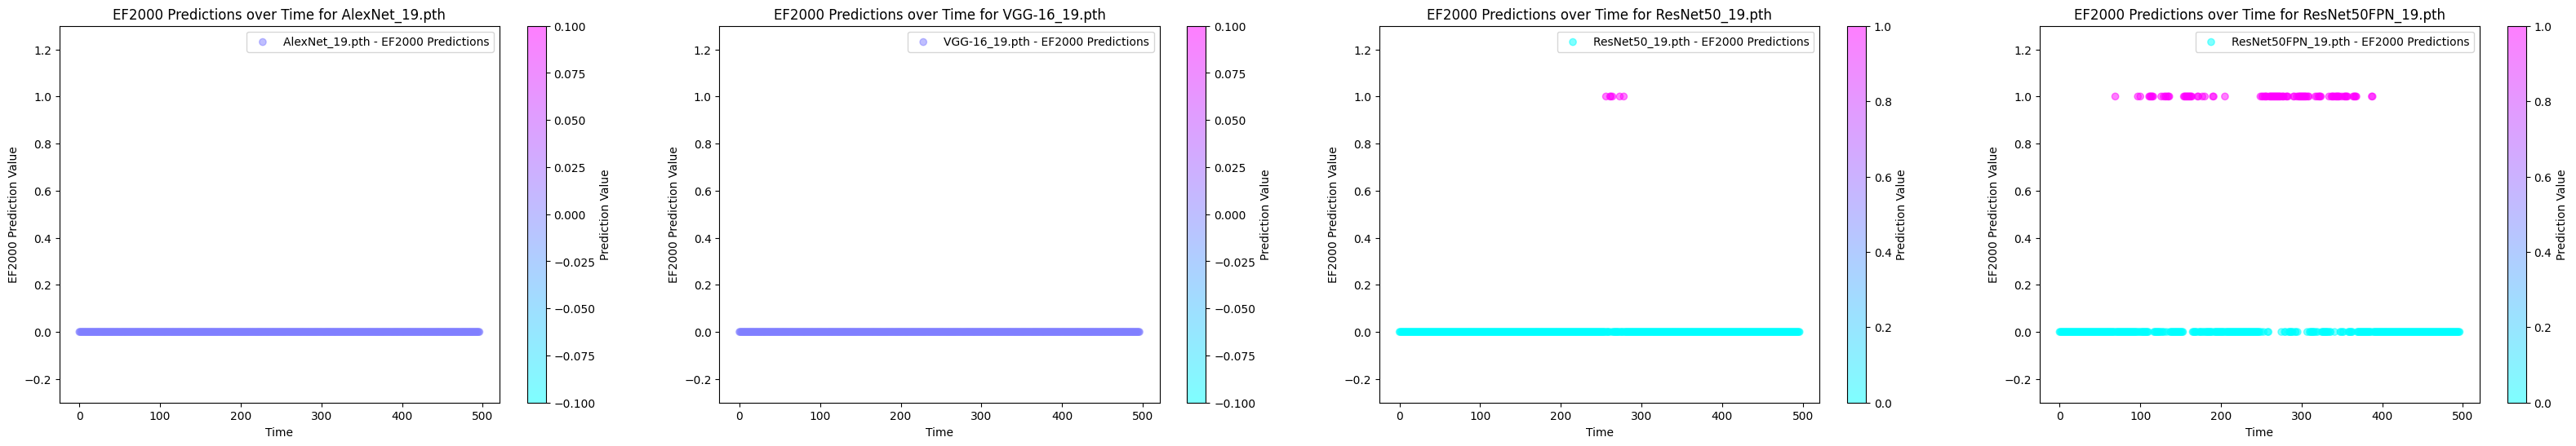

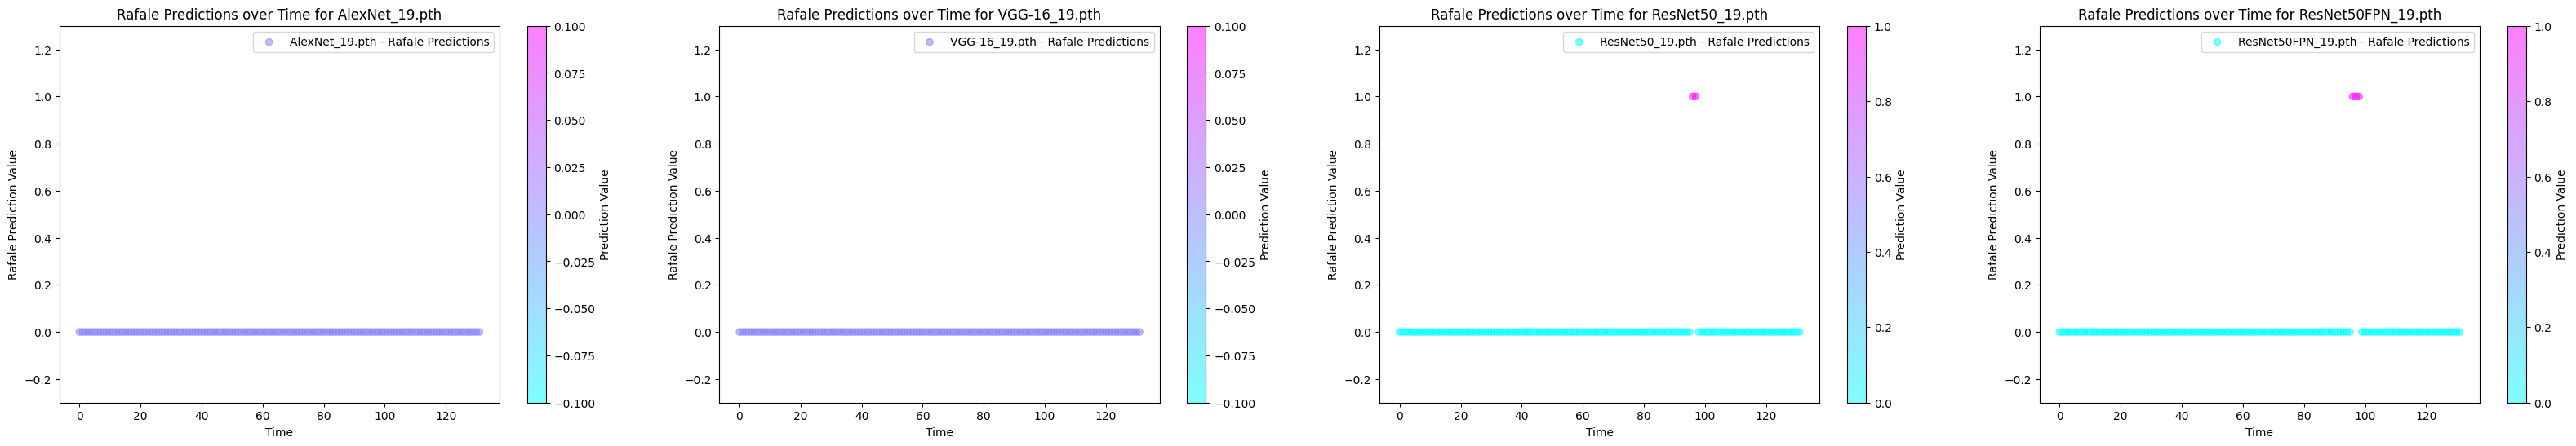

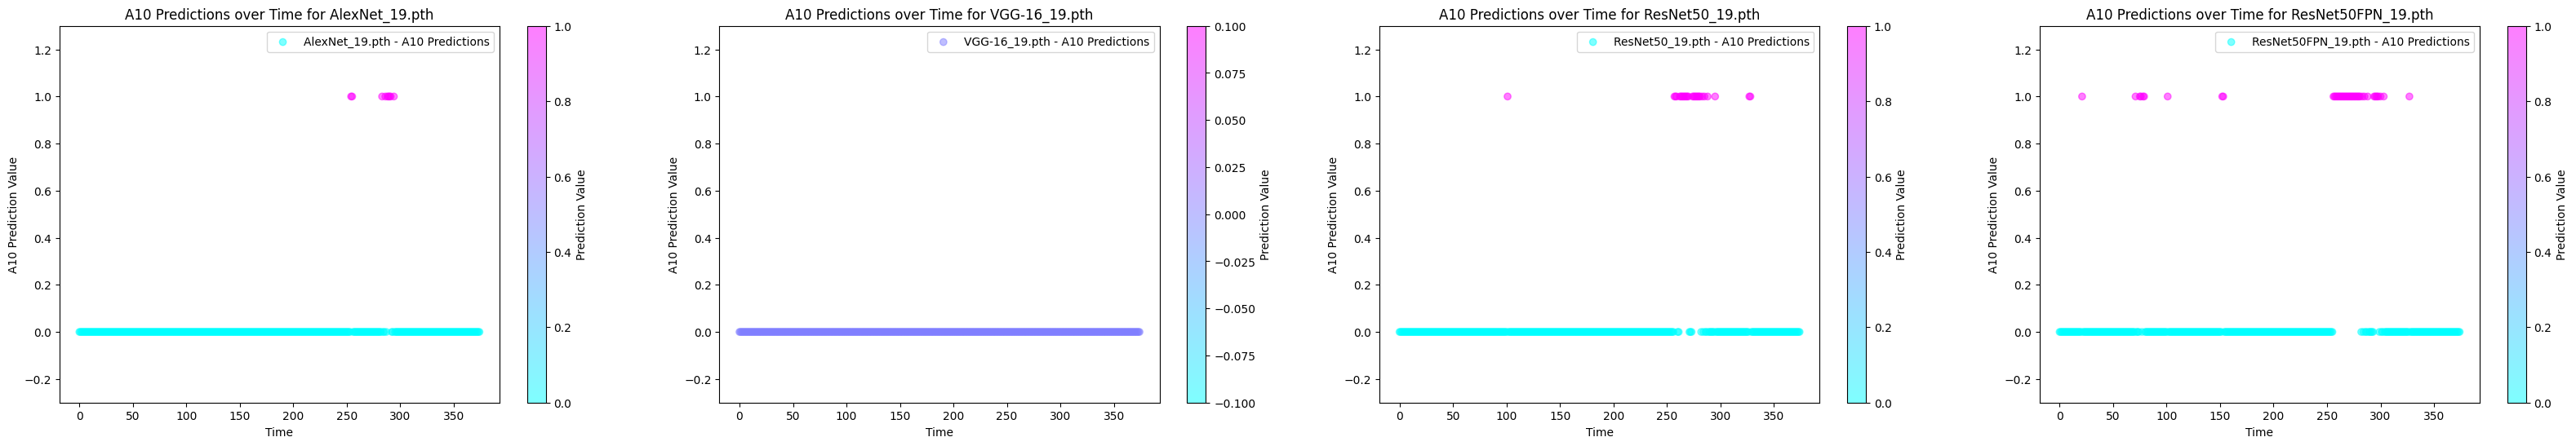

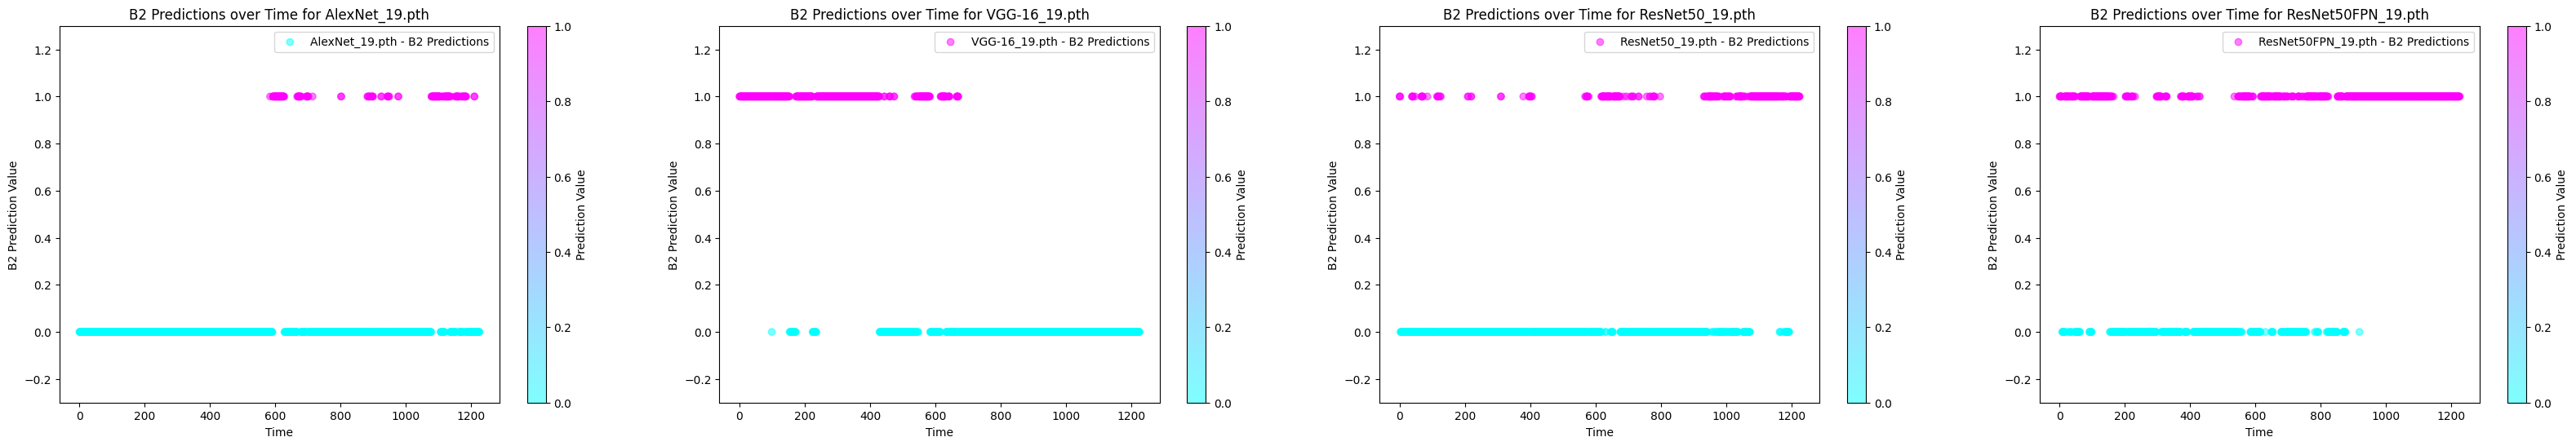

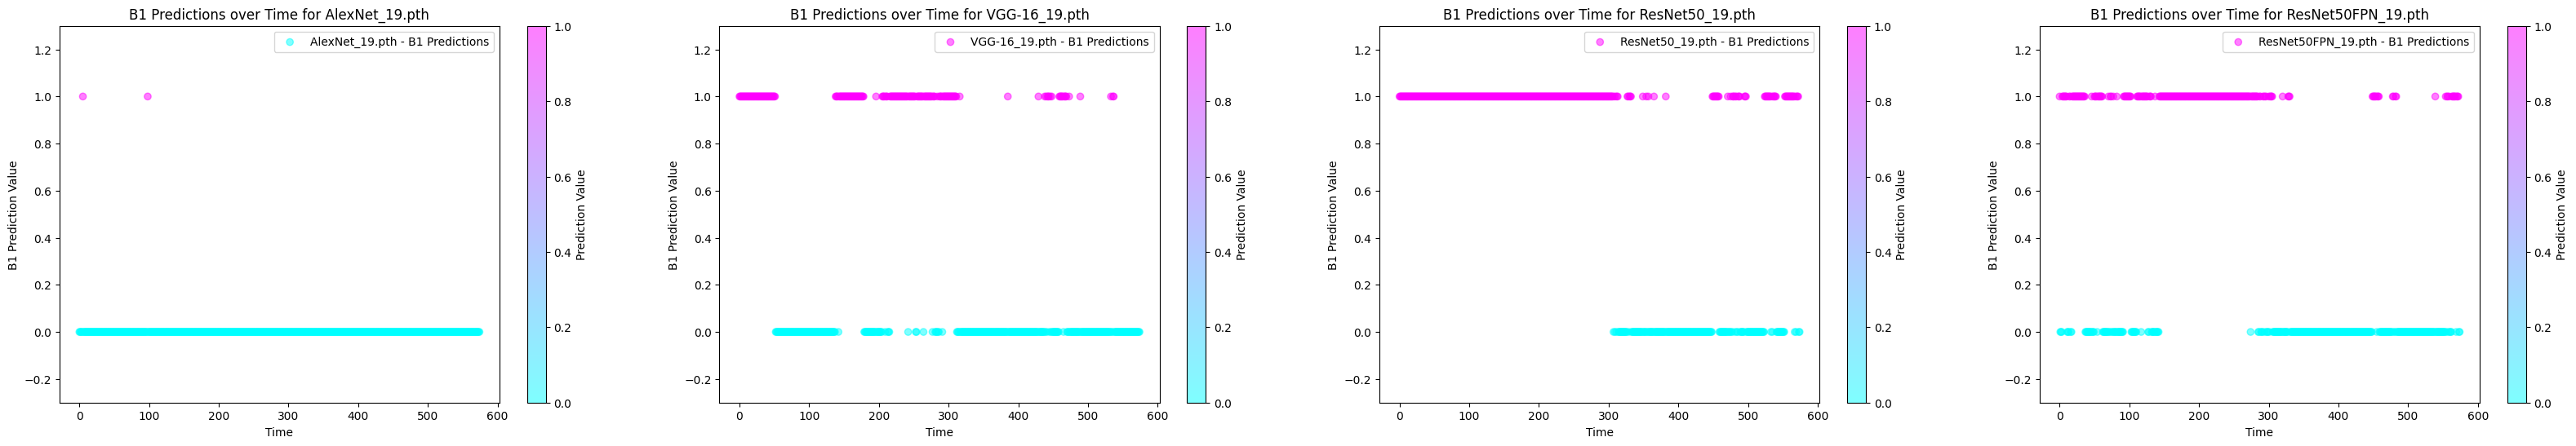

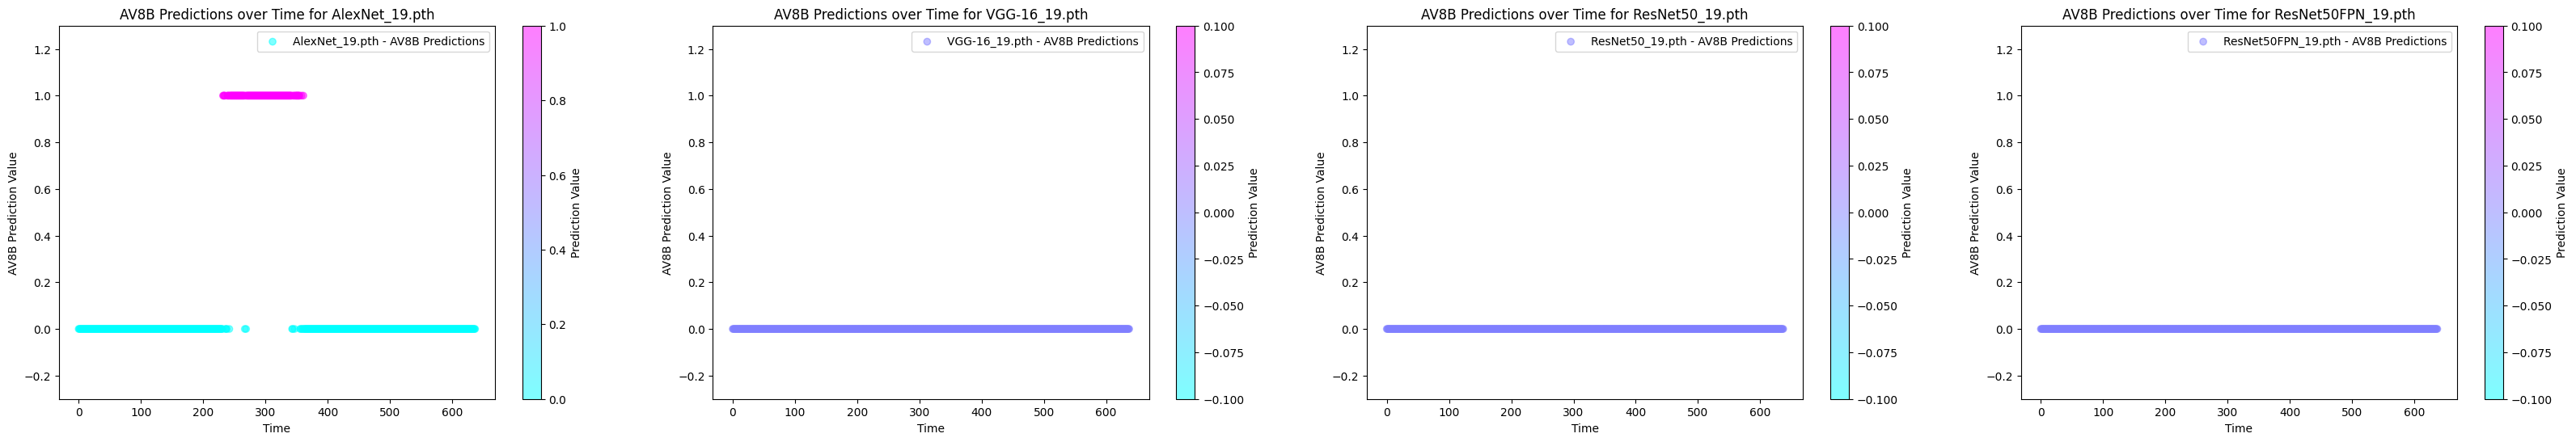

In [30]:
#printing prediction accuracy visualizations
prediction_accs = {}
for video in videos:
    videoname = os.path.basename(video)
    prediction_accs[videoname] = visualize_predictions(videoname)

In [31]:
pd.DataFrame.from_dict(prediction_accs)

,0_C17.mp4,1_V22.mp4,2_C5.mp4,3_F22.mp4,4_EF2000.mp4,5_Rafale.mp4,6_A10.mp4,7_B2.mp4,8_B1.mp4,9_AV8B.mp4
AlexNet_19.pth,0.026560,0.001276,0.061162,0.062937,0.000000,0.000000,0.024000,0.120718,0.003478,0.183386
VGG-16_19.pth,0.382470,0.271684,0.000000,0.073427,0.000000,0.000000,0.000000,0.386623,0.365217,0.000000
ResNet50_19.pth,0.000000,0.002551,0.460245,0.017483,0.012072,0.015152,0.072000,0.256117,0.655652,0.000000
ResNet50FPN_19.pth,0.001328,0.029337,0.339450,0.139860,0.217304,0.022727,0.122667,0.594617,0.450435,0.000000


In [32]:
import numpy as np

np.mean([11.758746441391992, 11.823181934398336, 11.804960636253586, 11.7944707350801, 11.680888318473002, 11.680888318473002, 12.36946169920343, 12.296583966170811, 11.813129913233338,11.820950380545133])


11.884326234322272